# TP deformable models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image
from skimage import io as skio
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage.segmentation import checkerboard_level_set
from skimage.segmentation import disk_level_set
import platform
import tempfile
import skimage.morphology as morpho
from skimage.morphology import disk
from skimage.draw import line
import skimage.feature as skf


In [ ]:
def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.diamond(taille)
    if forme == 'disk':
        return morpho.disk(taille)
    if forme == 'square':
        return morpho.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')


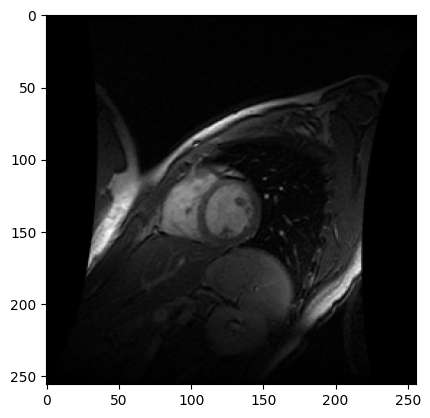

In [ ]:
im=skio.imread('coeurIRM.bmp')

#im=skio.imread('retineOA.bmp')

#im=skio.imread('brain.bmp')
#im=im[:,:,1]

#im=skio.imread('brain2.bmp')

plt.imshow(im, cmap="gray", vmin=0, vmax=255)

## Parameters

For each method, provide detailed explanations on:
- the interpretation of each parameter and its role,
- its influence on the segmentation result when varying its value.

### *skimage.segmentation.active_contour*
Active contours are deformable models used for object boundary detection in images. They evolve a curve by minimizing an energy function that balances internal forces (smoothness) and external forces (image gradients or edges) to fit the object's contours.

The method supports single and multichannel 2D images. It takes as input an image, the initial snake (active contour) coordinates, and some parameters for modifying the snake:

- **alpha**: Snake length shape parameter → with higher values, we make the snake contract faster.
- **beta**: Snake smoothness shape parameter → with higher values, we make the snake smoother.
- **w_edge**: Controls attraction to edges → with negative values, we make the snake repel from edges.
- **gamma**: Explicit time-stepping parameter.

Other than those, we can use other parameters (not used in the following code) for managing convergence, the iterations, the time step, and others.


### *skimage.segmentation.chan_vese*
Chan-Vese segmentation algorithm is designed to segment objects without clearly defined boundaries. Using the level set method, it iteratively evolves to minimize an energy function.

The method used is simplified compared to the original algorithm described in the paper by Tony Chan and Luminita Vese because the area factor *nu* from the original paper is not implemented and is not suitable for grayscale images.

Typical values for **lambda1** and **lambda2** are 1. However, these values can be varied in particular cases, such as when the background is very different from the segmented object in terms of distribution.

Typical values for **mu** are between 0 and 1, but higher values can be used when dealing with shapes with ill-defined contours. Higher **mu** values will produce a *round* edge, while values closer to 0 will detect smaller objects.

**tol** defines the level set variation tolerance between iterations → if the L2 norm difference between the level sets at two different iterations, normalized by the area of the image, is below this value, the algorithm will stop, assuming it has found the solution.

**dt** is a multiplication factor applied to calculations for each step, and it serves to accelerate the algorithm. Increasing the value of **dt** can speed up the algorithm, but it may lead to convergence issues.

**init_level_set** defines the starting level set used by the algorithm. The options are:
- checkerboard  
- disk  
- small disk


## Segmentation

For at least one of the four images and another of your choice (either another one among the provided images, or any other), propose a segmentation method, using one of the previous approaches, to segment some of the anatomical structures. Justify your choices, explain the obtained results, and discuss potential ideas to improve the results.

### Segmentation using active contours

In this experiment, we used the `alpha`, `beta`, and `w_edge` parameters to control the behavior of the active contour model for segmenting the heart in the MRI image. The initial contour was defined as a circle centered around the approximate region of interest. The `alpha` parameter (set to 0.1) regulated the snake's elasticity, allowing it to adapt to curved structures while maintaining some rigidity. A high `beta` value (150) prioritized smoothness, helping the snake avoid capturing small, noisy features. The `w_edge` parameter (50) emphasized edge attraction, guiding the contour to align with strong boundaries in the image. A small `gamma` (0.001) ensured slow, precise convergence of the snake to the desired shape. The best results were observed with these settings, as the snake accurately captured the external boundary of the heart while maintaining smoothness.

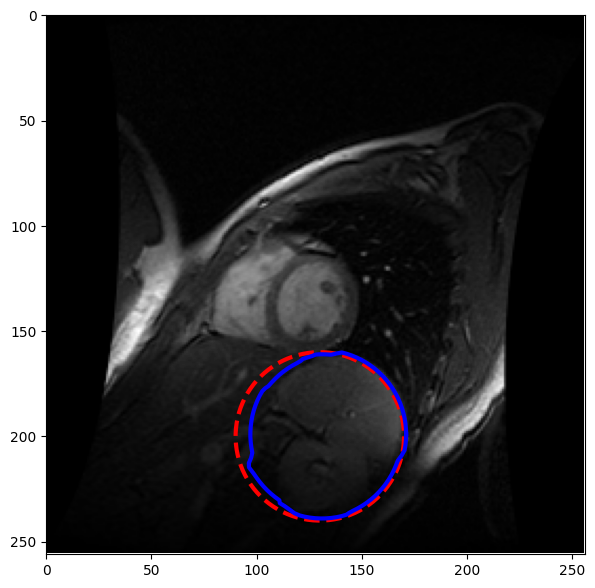

In [ ]:
im=skio.imread('coeurIRM.bmp')
s = np.linspace(0, 2*np.pi, 100)
r = 200 + 40 * np.sin(s)      #regulated by hands
c = 130 + 40 * np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(im, 0.1),
                       init, alpha=0.1, beta=150, w_edge=50, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.axis([0, im.shape[1], im.shape[0], 0])

plt.show()

In this task, we apply an active contour model (or "snake") to a heart MRI image to outline the heart's shape. We initialize a circular contour around the heart and adjust three parameters: alpha (controlling smoothness), beta (controlling stiffness), and w_edge (influencing the contour's attraction to image edges).

We visualize the results across a 3x3 grid, where each subplot shows how different combinations of these parameters affect the final contour. Lower alpha values allow the contour to capture more details, while higher beta values make the contour stiffer, and varying w_edge changes how strongly the contour sticks to the edges in the image.

The differences between the images reflect how these parameters balance contour flexibility and its alignment with the object’s boundaries.

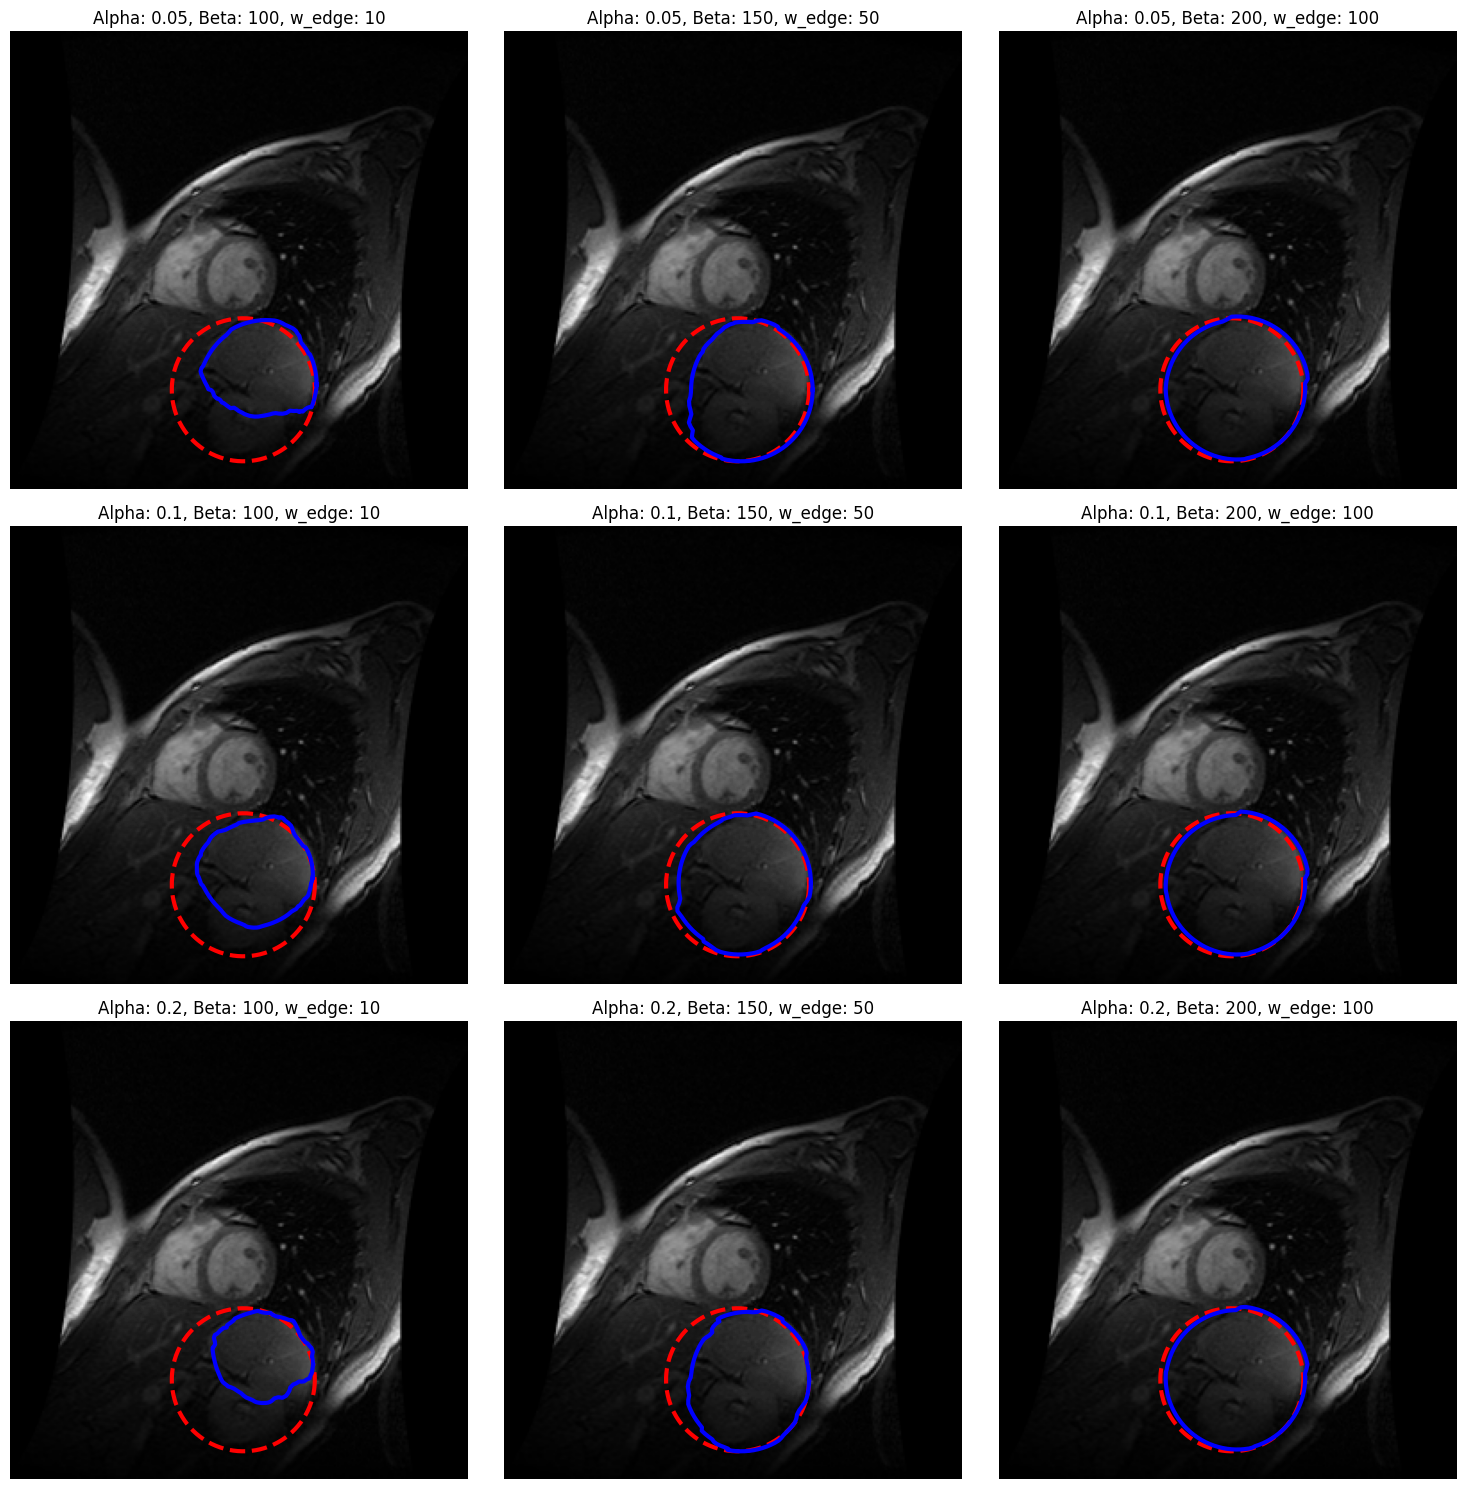

In [ ]:
im = skio.imread('coeurIRM.bmp')
alphas = [0.05, 0.1, 0.2]
betas = [100, 150, 200]
w_edges = [10, 50, 100]
gamma = 0.001
s = np.linspace(0, 2*np.pi, 100)
r = 200 + 40 * np.sin(s)
c = 130 + 40 * np.cos(s)
init = np.array([r, c]).T

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        snake = active_contour(gaussian(im, 0.1), init, alpha=alpha, beta=beta, w_edge=w_edges[j], gamma=gamma)
        ax = axes[i, j]
        ax.imshow(im, cmap=plt.cm.gray)
        ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
        ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
        ax.axis('off')
        ax.set_title(f'Alpha: {alpha}, Beta: {beta}, w_edge: {w_edges[j]}')

plt.tight_layout()
plt.show()


### Segmentation using level sets

In the experiments, we tuned the `lambda1` and `lambda2` parameters to prioritize internal or external structures in the brain segmentation. Higher `lambda1` values (Experiments 1-4) focused more on internal features like ventricles, while Experiment 5, with a higher `lambda2`, highlighted external boundaries. Lower `mu` values across experiments helped capture finer details but sometimes introduced noise. The best balance between internal and external features was observed in Experiment 3, while Experiment 5 mainly captured external contours.

### Summary Table

| Experiment | `mu`    | `lambda1` | `lambda2` | Focus              | Outcome |
|------------|---------|-----------|-----------|--------------------|---------|
| 1          | 0.01    | 5.0       | 1.0       | Strong internal     | Clear ventricles, weak boundaries |
| 2          | 0.005   | 4.5       | 1.0       | Internal focus with slight external balance | Improved outer boundary definition |
| 3          | 0.0025  | 3.5       | 1.0       | Balanced internal/external | More balanced segmentation |
| 4          | 0.001   | 3.0       | 1.0       | Balanced internal/external | Sharper boundaries, clear internal features |
| 5          | 0.1     | 2.0       | 4.5       | External boundary focus | Strong outer boundary, weak internal features |


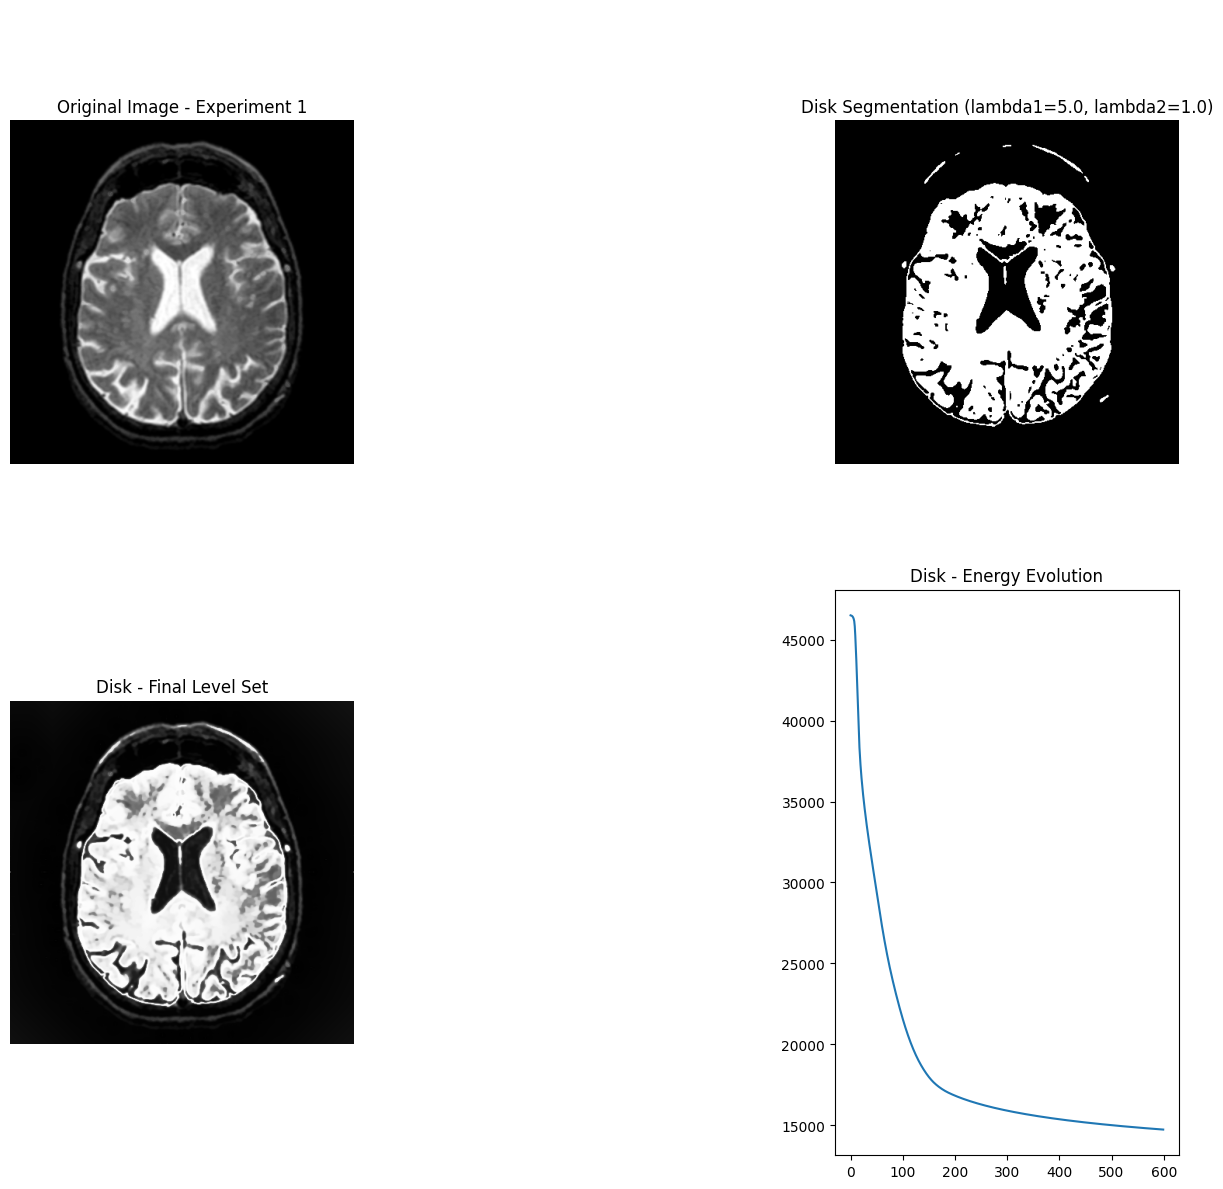

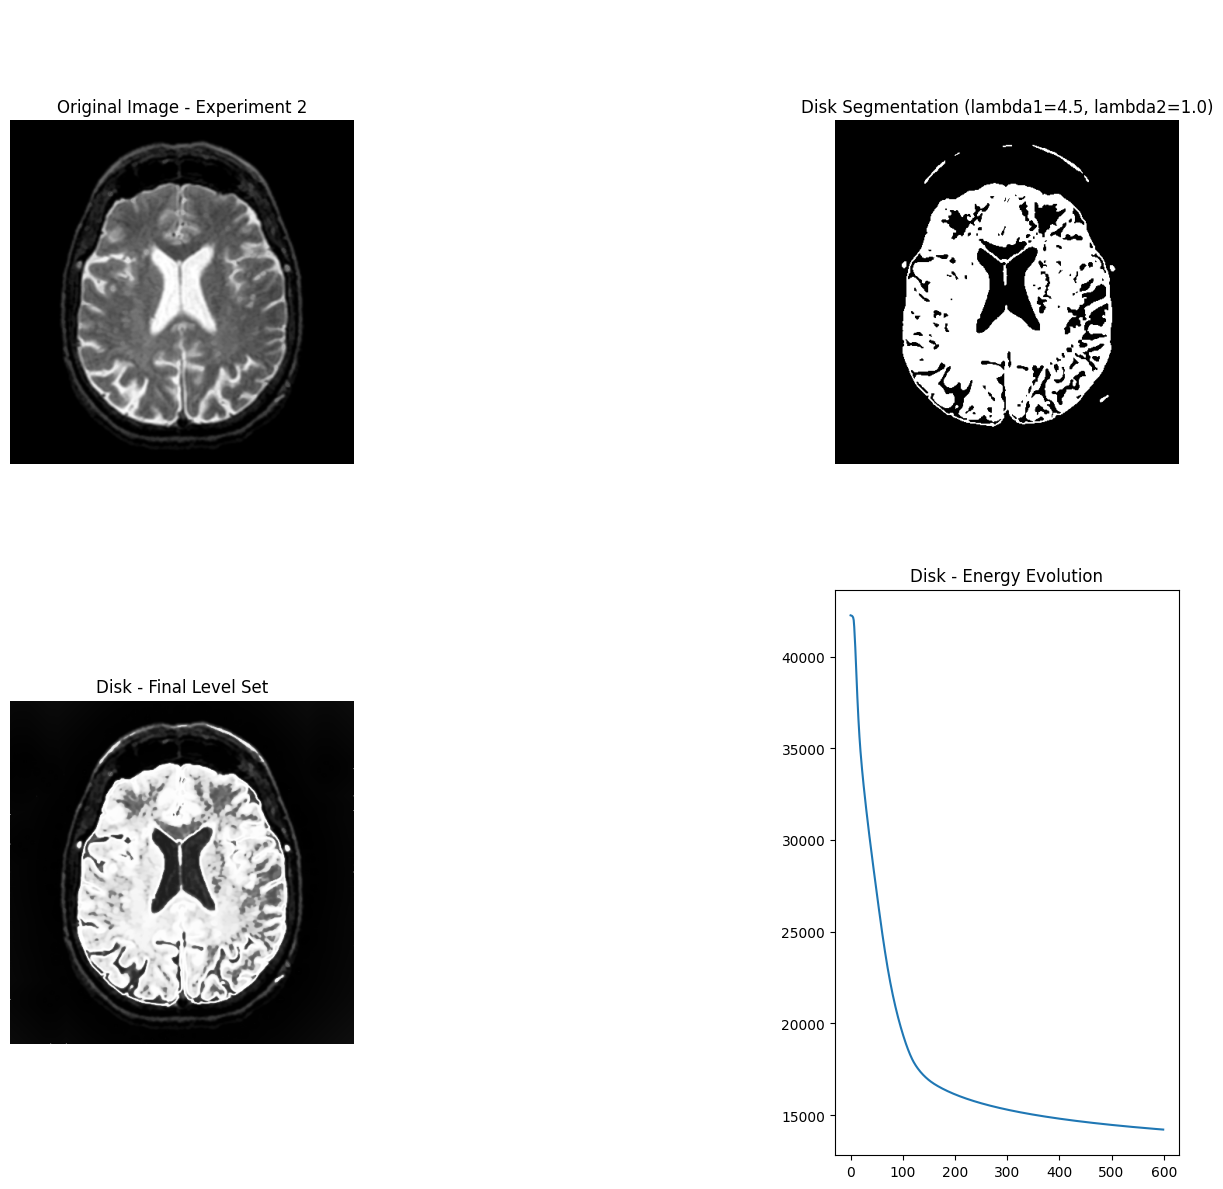

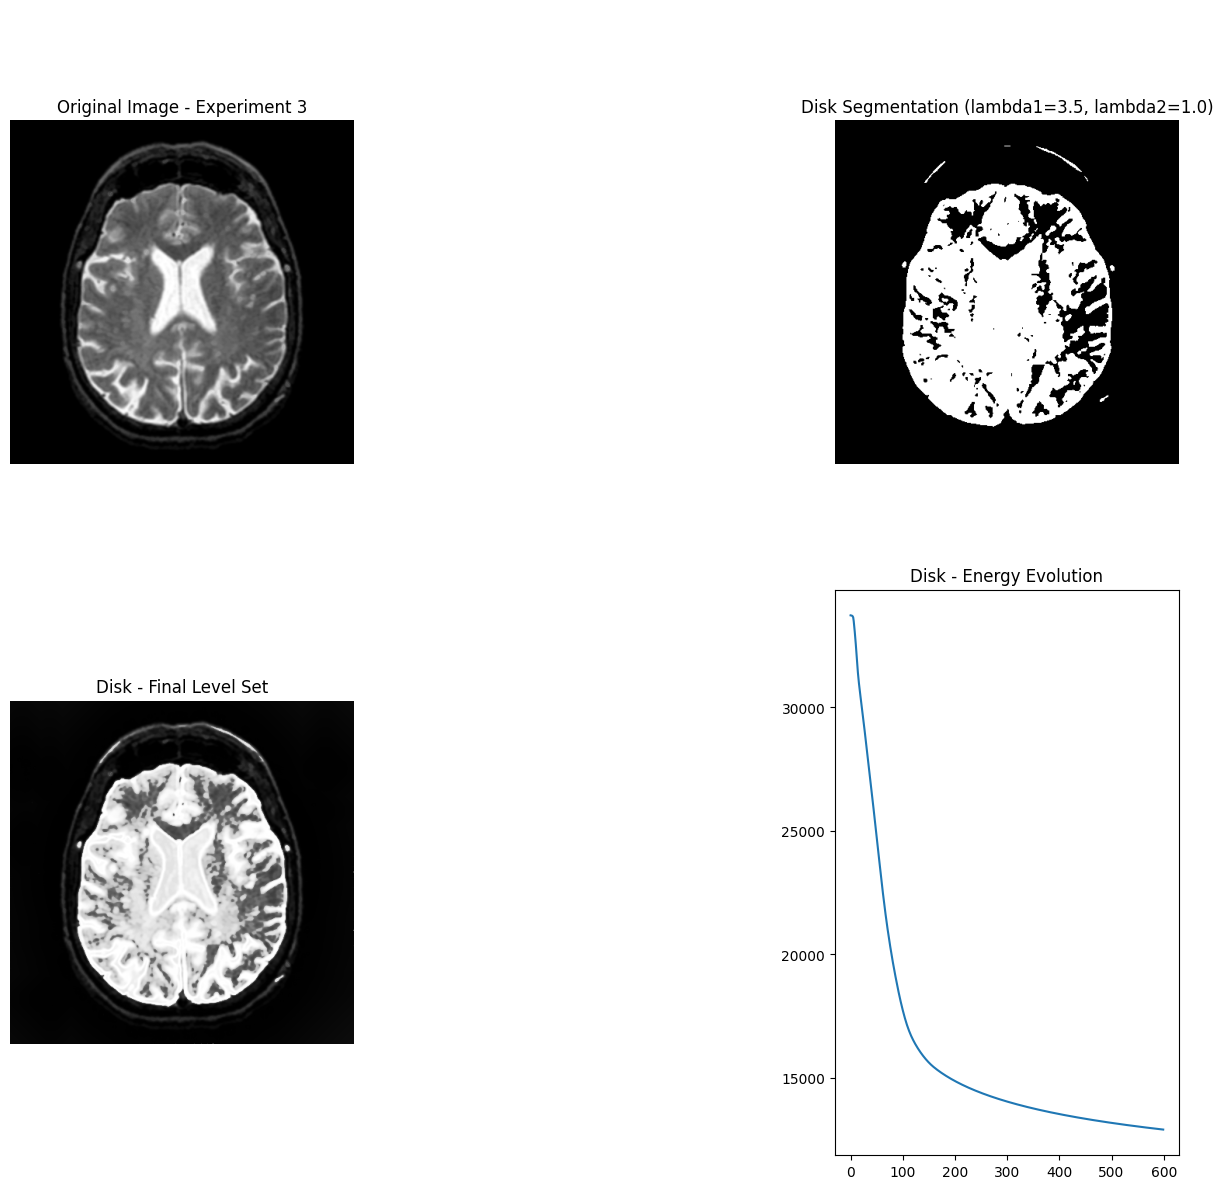

In [ ]:
image = img_as_float(skio.imread('brain.bmp'))
image = gaussian(image[:, :, 1], sigma=1.0)  # Apply Gaussian filter for noise reduction

se_dict = {}

opened_images = []

max_opening = np.zeros_like(image)

# After top-hat with line SE with different orientations
for t in (0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300):

    se_dict[t] = strel('line', 5, t)

    opened = morpho.opening(image, se_dict[t])

    opened_images.append(opened)

#compute the point-wise maximum of all the images
max_opening = np.maximum.reduce(opened_images)


init_ls_disk = disk_level_set(max_opening.shape)

# Define updated experiments with fine-tuned parameters
experiments = [
{'mu': 0.01, 'lambda1': 5.0, 'lambda2': 1.0, 'tol': 1e-4, 'dt': 0.5, 'max_iter': 600},  # Strong focus on internal
    {'mu': 0.005, 'lambda1': 4.5, 'lambda2': 1.0, 'tol': 1e-5, 'dt': 0.5, 'max_iter': 600},  # Slightly more balance but internal-biased
    {'mu': 0.0025, 'lambda1': 3.5, 'lambda2': 1.0, 'tol': 1e-5, 'dt': 0.5, 'max_iter': 600},  # Moderate focus on internal
    {'mu': 0.001, 'lambda1': 3.0, 'lambda2': 1.0, 'tol': 1e-5, 'dt': 0.5, 'max_iter': 600},
    {'mu': 0.1, 'lambda1': 2.0, 'lambda2': 4.5, 'tol': 1e-5, 'dt': 0.4, 'max_iter': 600},  # More balanced experiment
]


# Loop through each experiment, applying the Chan-Vese algorithm
# Loop through each experiment, applying the Chan-Vese algorithm
for i, params in enumerate(experiments):
    # Apply Chan-Vese segmentation
    cv_disk = chan_vese(max_opening, mu=params['mu'], lambda1=params['lambda1'], lambda2=params['lambda2'],
                        tol=params['tol'], max_num_iter=params['max_iter'], dt=params['dt'],
                        init_level_set=init_ls_disk, extended_output=True)

    # Create a 2x2 grid of subplots for this experiment
    fig, axs = plt.subplots(2, 3, figsize=(12, 12))  # 2 rows, 2 columns (4 plots per experiment)

    # Display the original image
    axs[0, 0].imshow(max_opening, cmap="gray")
    axs[0, 0].set_axis_off()
    axs[0, 0].set_title(f"Original Image - Experiment {i+1}", fontsize=12)

    # Display the segmentation result
    axs[0, 2].imshow(cv_disk[0], cmap="gray")
    axs[0, 2].set_axis_off()
    axs[0, 2].set_title(f"Disk Segmentation (lambda1={params['lambda1']}, lambda2={params['lambda2']})", fontsize=12)

    # Display the final level set
    axs[1, 0].imshow(cv_disk[1], cmap="gray")
    axs[1, 0].set_axis_off()
    axs[1, 0].set_title("Disk - Final Level Set", fontsize=12)

    # Plot the energy evolution over iterations
    axs[1, 2].plot(cv_disk[2])
    axs[1, 2].set_title("Disk - Energy Evolution", fontsize=12)

    axs[0,1].set_axis_off()
    axs[1,1].set_axis_off()
    # Adjust layout and show plot
    fig.tight_layout()
    plt.show()
